In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "/home/mx19/datasets/hot-dog-not-hot-dog/"
print("The data lies here =>", root_dir)

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

hotdog_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )

print(hotdog_dataset)
print(hotdog_dataset.class_to_idx)


We're using => cuda
The data lies here => /home/mx19/datasets/hot-dog-not-hot-dog/
Dataset ImageFolder
    Number of datapoints: 498
    Root location: /home/mx19/datasets/hot-dog-not-hot-dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
{'hot_dog': 0, 'not_hot_dog': 1}


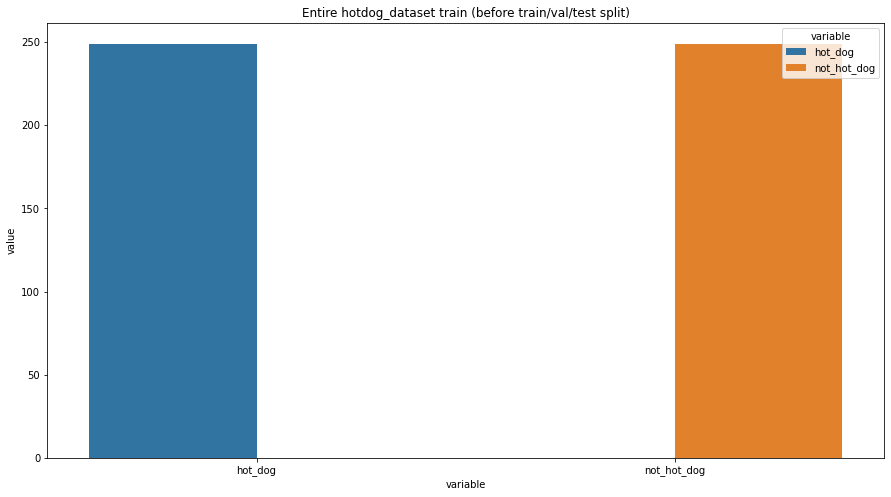

In [3]:
idx2class = {v: k for k, v in hotdog_dataset.class_to_idx.items()}
##print(idx2class) #{0: 'hot_dog', 1: 'not_hot_dog'}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


##print(get_class_distribution(hotdog_dataset)) #{'hot_dog': 249, 'not_hot_dog': 249}

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(hotdog_dataset), plot_title="Entire hotdog_dataset train (before train/val/test split)")
plt.show()


val_split_index 99
train_idx [208, 107, 397, 71, 482, 6, 410, 113, 236, 299, 155, 272, 7, 137, 8, 429, 430, 366, 284, 210, 188, 428, 49, 134, 363, 408, 239, 59, 493, 461, 409, 483, 229, 297, 55, 293, 488, 456, 455, 421, 186, 194, 52, 74, 26, 486, 4, 318, 329, 245, 5, 141, 381, 135, 491, 122, 22, 68, 20, 367, 14, 278, 225, 64, 379, 231, 81, 354, 302, 497, 469, 453, 160, 476, 362, 494, 206, 319, 51, 306, 450, 330, 164, 106, 479, 63, 342, 425, 437, 320, 89, 312, 460, 93, 298, 457, 308, 393, 92, 18, 198, 145, 158, 150, 477, 167, 255, 230, 433, 66, 309, 253, 140, 101, 387, 2, 406, 17, 146, 249, 263, 30, 114, 247, 103, 403, 310, 176, 246, 116, 168, 413, 120, 261, 112, 417, 418, 282, 136, 190, 345, 181, 126, 281, 252, 405, 371, 352, 232, 133, 33, 474, 162, 34, 44, 97, 85, 61, 199, 268, 218, 73, 35, 303, 29, 490, 339, 441, 217, 27, 332, 378, 156, 470, 343, 138, 212, 104, 348, 344, 422, 215, 383, 189, 214, 204, 234, 259, 67, 24, 216, 223, 129, 111, 166, 415, 392, 40, 274, 355, 79, 313, 315, 13,

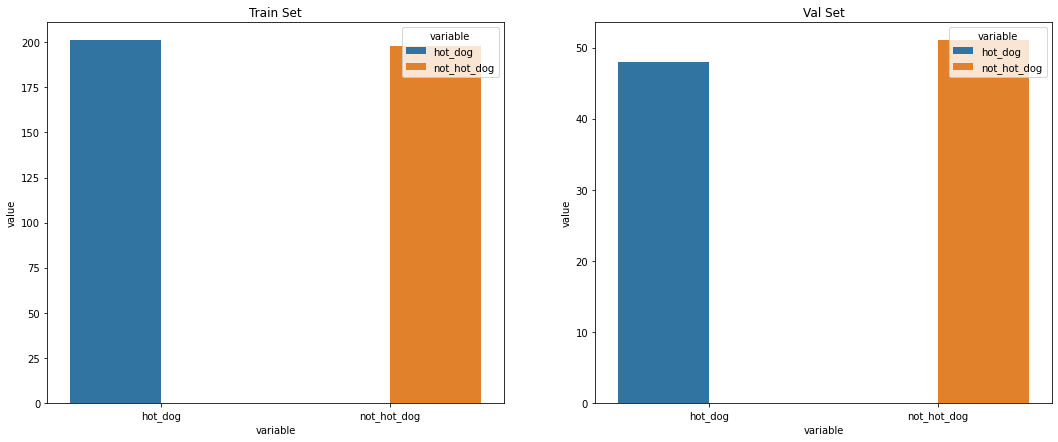

In [4]:
###########################
##### TEST

##Load our test dataset.

hotdog_dataset_size = len(hotdog_dataset)
hotdog_dataset_indices = list(range(hotdog_dataset_size))
#print(hotdog_dataset_size) # 498
#print(hotdog_dataset_indices) # [0, 1, 2, 3 ...... 495, 496, 497]

np.random.shuffle(hotdog_dataset_indices)

# train_split_index = int(np.floor(0.03 * hotdog_dataset_size))
# val_split_index = int(np.floor(0.97 * hotdog_dataset_size))
val_split_index = int(np.floor(0.2 * hotdog_dataset_size))
#print(f'train_split_index {train_split_index}')
print(f'val_split_index {val_split_index}')

train_idx = hotdog_dataset_indices[val_split_index:]
val_idx = hotdog_dataset_indices[:val_split_index]
print(f'train_idx {train_idx}') # [train_split_index ...  hotdog_dataset_size]
print(f'val_idx {val_idx}') # [0... val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=hotdog_dataset, shuffle=False, batch_size=1, sampler=val_sampler)


print(train_loader.dataset)
print(val_loader.dataset)



hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=False, batch_size=1)
print(f'hotdog_dataset_test: {hotdog_dataset_test}')


def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict


print(get_class_distribution_loaders(train_loader, hotdog_dataset))
print(get_class_distribution_loaders(val_loader, hotdog_dataset))
print(get_class_distribution_loaders(test_loader, hotdog_dataset))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, hotdog_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(val_loader, hotdog_dataset), plot_title="Val Set", ax=axes[1])
plt.show()


torch.Size([8, 3, 224, 224])
Output label tensors:  tensor([0, 1, 1, 1, 0, 1, 0, 1])

Output label tensor shape:  torch.Size([8])
torch.Size([3, 224, 224])


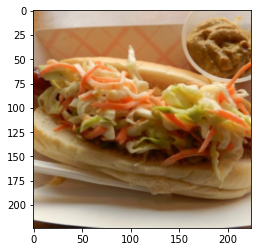

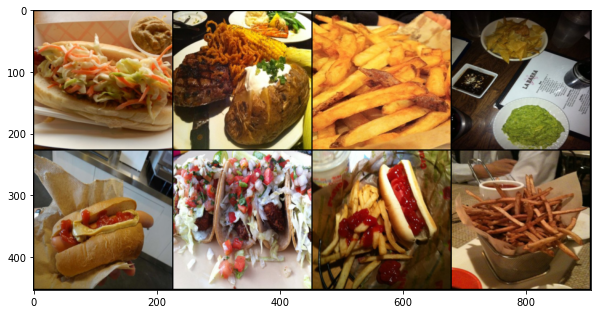

In [5]:
single_batch = next(iter(train_loader))
#single_batch = next(iter(val_loader))
print(single_batch[0].shape)

print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)


# Selecting the first image tensor from the batch.
single_image = single_batch[0][0]
print(single_image.shape)
plt.imshow(single_image.cpu().detach().numpy().transpose((1, 2, 0)))
plt.show()

# We do single_batch[0] because each batch is a list
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))
plt.show()


In [6]:
class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x

    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block


model = HotDogClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)



HotDogClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [7]:
# function to calculate accuracy per epoch.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc


#We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


In [8]:
#########################
## Let’s TRAIN our model!


print("Begin training.")
epoch_number = 101

for e in tqdm(range(1, epoch_number)):

    ## TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    ## VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))

    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
            
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    print(f'Epoch {e+0:02}:' )

Begin training.


  0%|                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]/home/mx19/anaconda3/envs/codeVE/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  1%|█▌                                                                                                                                                       | 1/100 [00:06<11:17,  6.84s/it]

Epoch 01: | Train Loss: 122.38521 | Val Loss: 107.03701 | Train Acc: 53.820| Val Acc: 62.626
Epoch 01:


  2%|███                                                                                                                                                      | 2/100 [00:12<09:53,  6.06s/it]

Epoch 02: | Train Loss: 55.00733 | Val Loss: 47.97807 | Train Acc: 59.380| Val Acc: 61.616
Epoch 02:


  3%|████▌                                                                                                                                                    | 3/100 [00:17<09:25,  5.83s/it]

Epoch 03: | Train Loss: 25.22521 | Val Loss: 42.56826 | Train Acc: 72.600| Val Acc: 61.616
Epoch 03:


  4%|██████                                                                                                                                                   | 4/100 [00:23<09:11,  5.75s/it]

Epoch 04: | Train Loss: 18.21403 | Val Loss: 62.69755 | Train Acc: 77.460| Val Acc: 52.525
Epoch 04:


  5%|███████▋                                                                                                                                                 | 5/100 [00:29<09:02,  5.71s/it]

Epoch 05: | Train Loss: 9.70856 | Val Loss: 43.58798 | Train Acc: 79.800| Val Acc: 53.535
Epoch 05:


  6%|█████████▏                                                                                                                                               | 6/100 [00:34<08:55,  5.69s/it]

Epoch 06: | Train Loss: 7.50414 | Val Loss: 27.34294 | Train Acc: 82.360| Val Acc: 60.606
Epoch 06:


  7%|██████████▋                                                                                                                                              | 7/100 [00:40<08:48,  5.68s/it]

Epoch 07: | Train Loss: 7.27412 | Val Loss: 23.71472 | Train Acc: 82.340| Val Acc: 59.596
Epoch 07:


  8%|████████████▏                                                                                                                                            | 8/100 [00:46<08:42,  5.68s/it]

Epoch 08: | Train Loss: 3.04870 | Val Loss: 23.39891 | Train Acc: 87.200| Val Acc: 55.556
Epoch 08:


  9%|█████████████▊                                                                                                                                           | 9/100 [00:51<08:38,  5.70s/it]

Epoch 09: | Train Loss: 2.44931 | Val Loss: 18.69317 | Train Acc: 88.800| Val Acc: 61.616
Epoch 09:


 10%|███████████████▏                                                                                                                                        | 10/100 [00:57<08:32,  5.69s/it]

Epoch 10: | Train Loss: 1.61035 | Val Loss: 17.26266 | Train Acc: 89.860| Val Acc: 59.596
Epoch 10:


 11%|████████████████▋                                                                                                                                       | 11/100 [01:03<08:28,  5.72s/it]

Epoch 11: | Train Loss: 0.79319 | Val Loss: 18.89352 | Train Acc: 93.620| Val Acc: 51.515
Epoch 11:


 12%|██████████████████▏                                                                                                                                     | 12/100 [01:09<08:25,  5.74s/it]

Epoch 12: | Train Loss: 0.76765 | Val Loss: 19.16105 | Train Acc: 95.820| Val Acc: 54.545
Epoch 12:


 13%|███████████████████▊                                                                                                                                    | 13/100 [01:14<08:18,  5.74s/it]

Epoch 13: | Train Loss: 0.91681 | Val Loss: 17.94823 | Train Acc: 93.860| Val Acc: 60.606
Epoch 13:


 14%|█████████████████████▎                                                                                                                                  | 14/100 [01:20<08:10,  5.71s/it]

Epoch 14: | Train Loss: 0.76429 | Val Loss: 17.40756 | Train Acc: 94.620| Val Acc: 60.606
Epoch 14:


 15%|██████████████████████▊                                                                                                                                 | 15/100 [01:26<08:07,  5.74s/it]

Epoch 15: | Train Loss: 0.39909 | Val Loss: 16.59530 | Train Acc: 95.340| Val Acc: 59.596
Epoch 15:


 16%|████████████████████████▎                                                                                                                               | 16/100 [01:32<08:06,  5.80s/it]

Epoch 16: | Train Loss: 0.30079 | Val Loss: 16.75409 | Train Acc: 96.620| Val Acc: 56.566
Epoch 16:


 17%|█████████████████████████▊                                                                                                                              | 17/100 [01:37<07:59,  5.78s/it]

Epoch 17: | Train Loss: 0.16907 | Val Loss: 18.08484 | Train Acc: 97.080| Val Acc: 55.556
Epoch 17:


 18%|███████████████████████████▎                                                                                                                            | 18/100 [01:43<07:51,  5.75s/it]

Epoch 18: | Train Loss: 0.24558 | Val Loss: 16.62453 | Train Acc: 96.580| Val Acc: 52.525
Epoch 18:


 19%|████████████████████████████▉                                                                                                                           | 19/100 [01:49<07:44,  5.73s/it]

Epoch 19: | Train Loss: 0.46257 | Val Loss: 15.87080 | Train Acc: 95.860| Val Acc: 56.566
Epoch 19:


 20%|██████████████████████████████▍                                                                                                                         | 20/100 [01:55<07:36,  5.71s/it]

Epoch 20: | Train Loss: 0.68193 | Val Loss: 12.28379 | Train Acc: 93.900| Val Acc: 59.596
Epoch 20:


 21%|███████████████████████████████▉                                                                                                                        | 21/100 [02:00<07:31,  5.72s/it]

Epoch 21: | Train Loss: 1.10049 | Val Loss: 15.42334 | Train Acc: 92.400| Val Acc: 54.545
Epoch 21:


 22%|█████████████████████████████████▍                                                                                                                      | 22/100 [02:06<07:29,  5.76s/it]

Epoch 22: | Train Loss: 0.54489 | Val Loss: 13.59052 | Train Acc: 93.900| Val Acc: 56.566
Epoch 22:


 23%|██████████████████████████████████▉                                                                                                                     | 23/100 [02:12<07:25,  5.79s/it]

Epoch 23: | Train Loss: 0.36536 | Val Loss: 15.02016 | Train Acc: 96.640| Val Acc: 54.545
Epoch 23:


 24%|████████████████████████████████████▍                                                                                                                   | 24/100 [02:18<07:22,  5.82s/it]

Epoch 24: | Train Loss: 0.33775 | Val Loss: 10.29787 | Train Acc: 95.600| Val Acc: 59.596
Epoch 24:


 25%|██████████████████████████████████████                                                                                                                  | 25/100 [02:24<07:17,  5.84s/it]

Epoch 25: | Train Loss: 0.13937 | Val Loss: 9.84199 | Train Acc: 97.520| Val Acc: 61.616
Epoch 25:


 26%|███████████████████████████████████████▌                                                                                                                | 26/100 [02:30<07:12,  5.84s/it]

Epoch 26: | Train Loss: 0.27378 | Val Loss: 12.82664 | Train Acc: 96.620| Val Acc: 53.535
Epoch 26:


 27%|█████████████████████████████████████████                                                                                                               | 27/100 [02:35<07:04,  5.82s/it]

Epoch 27: | Train Loss: 0.21424 | Val Loss: 12.77692 | Train Acc: 98.800| Val Acc: 56.566
Epoch 27:


 28%|██████████████████████████████████████████▌                                                                                                             | 28/100 [02:41<06:57,  5.80s/it]

Epoch 28: | Train Loss: 0.18224 | Val Loss: 11.67195 | Train Acc: 97.720| Val Acc: 53.535
Epoch 28:


 29%|████████████████████████████████████████████                                                                                                            | 29/100 [02:47<06:50,  5.79s/it]

Epoch 29: | Train Loss: 0.62646 | Val Loss: 13.11890 | Train Acc: 93.880| Val Acc: 57.576
Epoch 29:


 30%|█████████████████████████████████████████████▌                                                                                                          | 30/100 [02:53<06:44,  5.78s/it]

Epoch 30: | Train Loss: 0.67367 | Val Loss: 11.49853 | Train Acc: 94.180| Val Acc: 58.586
Epoch 30:


 31%|███████████████████████████████████████████████                                                                                                         | 31/100 [02:58<06:38,  5.77s/it]

Epoch 31: | Train Loss: 0.34934 | Val Loss: 10.95867 | Train Acc: 95.400| Val Acc: 50.505
Epoch 31:


 32%|████████████████████████████████████████████████▋                                                                                                       | 32/100 [03:04<06:32,  5.77s/it]

Epoch 32: | Train Loss: 0.64197 | Val Loss: 13.87215 | Train Acc: 93.160| Val Acc: 65.657
Epoch 32:


 33%|██████████████████████████████████████████████████▏                                                                                                     | 33/100 [03:10<06:25,  5.75s/it]

Epoch 33: | Train Loss: 0.46079 | Val Loss: 10.24186 | Train Acc: 94.880| Val Acc: 57.576
Epoch 33:


 34%|███████████████████████████████████████████████████▋                                                                                                    | 34/100 [03:16<06:20,  5.77s/it]

Epoch 34: | Train Loss: 0.24751 | Val Loss: 11.05118 | Train Acc: 96.120| Val Acc: 55.556
Epoch 34:


 35%|█████████████████████████████████████████████████████▏                                                                                                  | 35/100 [03:21<06:14,  5.76s/it]

Epoch 35: | Train Loss: 0.20560 | Val Loss: 9.58690 | Train Acc: 97.320| Val Acc: 57.576
Epoch 35:


 36%|██████████████████████████████████████████████████████▋                                                                                                 | 36/100 [03:27<06:08,  5.75s/it]

Epoch 36: | Train Loss: 0.35647 | Val Loss: 9.16603 | Train Acc: 95.860| Val Acc: 53.535
Epoch 36:


 37%|████████████████████████████████████████████████████████▏                                                                                               | 37/100 [03:33<06:01,  5.74s/it]

Epoch 37: | Train Loss: 0.21324 | Val Loss: 10.55059 | Train Acc: 98.040| Val Acc: 55.556
Epoch 37:


 38%|█████████████████████████████████████████████████████████▊                                                                                              | 38/100 [03:39<05:56,  5.75s/it]

Epoch 38: | Train Loss: 0.25060 | Val Loss: 9.96735 | Train Acc: 97.840| Val Acc: 54.545
Epoch 38:


 39%|███████████████████████████████████████████████████████████▎                                                                                            | 39/100 [03:44<05:50,  5.75s/it]

Epoch 39: | Train Loss: 0.14443 | Val Loss: 8.64991 | Train Acc: 97.320| Val Acc: 58.586
Epoch 39:


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 40/100 [03:50<05:44,  5.74s/it]

Epoch 40: | Train Loss: 0.07341 | Val Loss: 10.21895 | Train Acc: 97.580| Val Acc: 58.586
Epoch 40:


 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 41/100 [03:56<05:38,  5.74s/it]

Epoch 41: | Train Loss: 0.10605 | Val Loss: 8.37144 | Train Acc: 98.300| Val Acc: 55.556
Epoch 41:


 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 42/100 [04:02<05:32,  5.74s/it]

Epoch 42: | Train Loss: 0.10117 | Val Loss: 10.12250 | Train Acc: 97.820| Val Acc: 57.576
Epoch 42:


 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 43/100 [04:07<05:27,  5.74s/it]

Epoch 43: | Train Loss: 0.15473 | Val Loss: 10.90741 | Train Acc: 97.360| Val Acc: 58.586
Epoch 43:


 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 44/100 [04:13<05:21,  5.74s/it]

Epoch 44: | Train Loss: 0.43597 | Val Loss: 10.93865 | Train Acc: 94.540| Val Acc: 57.576
Epoch 44:


 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 45/100 [04:19<05:15,  5.74s/it]

Epoch 45: | Train Loss: 0.23656 | Val Loss: 10.44116 | Train Acc: 97.320| Val Acc: 53.535
Epoch 45:


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 46/100 [04:25<05:10,  5.75s/it]

Epoch 46: | Train Loss: 0.44340 | Val Loss: 9.36460 | Train Acc: 95.620| Val Acc: 58.586
Epoch 46:


 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 47/100 [04:30<05:04,  5.75s/it]

Epoch 47: | Train Loss: 0.35056 | Val Loss: 8.74758 | Train Acc: 96.120| Val Acc: 57.576
Epoch 47:


 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 48/100 [04:36<04:58,  5.73s/it]

Epoch 48: | Train Loss: 0.27349 | Val Loss: 8.22139 | Train Acc: 96.380| Val Acc: 56.566
Epoch 48:


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 49/100 [04:42<04:51,  5.72s/it]

Epoch 49: | Train Loss: 0.26546 | Val Loss: 10.25937 | Train Acc: 96.340| Val Acc: 61.616
Epoch 49:


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 50/100 [04:47<04:45,  5.71s/it]

Epoch 50: | Train Loss: 0.24058 | Val Loss: 10.07095 | Train Acc: 96.340| Val Acc: 54.545
Epoch 50:


 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                          | 51/100 [04:53<04:39,  5.70s/it]

Epoch 51: | Train Loss: 0.41093 | Val Loss: 8.14114 | Train Acc: 94.100| Val Acc: 57.576
Epoch 51:


 52%|███████████████████████████████████████████████████████████████████████████████                                                                         | 52/100 [04:59<04:33,  5.69s/it]

Epoch 52: | Train Loss: 0.36000 | Val Loss: 8.32952 | Train Acc: 96.280| Val Acc: 60.606
Epoch 52:


 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 53/100 [05:04<04:27,  5.70s/it]

Epoch 53: | Train Loss: 0.26162 | Val Loss: 9.20115 | Train Acc: 95.320| Val Acc: 54.545
Epoch 53:


 54%|██████████████████████████████████████████████████████████████████████████████████                                                                      | 54/100 [05:10<04:22,  5.70s/it]

Epoch 54: | Train Loss: 0.63821 | Val Loss: 9.33168 | Train Acc: 94.120| Val Acc: 61.616
Epoch 54:


 55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                    | 55/100 [05:16<04:16,  5.70s/it]

Epoch 55: | Train Loss: 0.65643 | Val Loss: 11.59498 | Train Acc: 94.400| Val Acc: 51.515
Epoch 55:


 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                   | 56/100 [05:22<04:10,  5.69s/it]

Epoch 56: | Train Loss: 0.53167 | Val Loss: 11.58260 | Train Acc: 94.380| Val Acc: 60.606
Epoch 56:


 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 57/100 [05:27<04:04,  5.69s/it]

Epoch 57: | Train Loss: 0.60454 | Val Loss: 10.90454 | Train Acc: 94.120| Val Acc: 61.616
Epoch 57:


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 58/100 [05:33<03:58,  5.68s/it]

Epoch 58: | Train Loss: 0.94693 | Val Loss: 10.03057 | Train Acc: 92.580| Val Acc: 59.596
Epoch 58:


 59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 59/100 [05:39<03:52,  5.68s/it]

Epoch 59: | Train Loss: 0.55857 | Val Loss: 12.34287 | Train Acc: 93.920| Val Acc: 58.586
Epoch 59:


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 60/100 [05:44<03:47,  5.68s/it]

Epoch 60: | Train Loss: 0.37073 | Val Loss: 5.79383 | Train Acc: 95.880| Val Acc: 64.646
Epoch 60:


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 61/100 [05:50<03:41,  5.68s/it]

Epoch 61: | Train Loss: 0.23269 | Val Loss: 8.52281 | Train Acc: 95.840| Val Acc: 51.515
Epoch 61:


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 62/100 [05:56<03:35,  5.68s/it]

Epoch 62: | Train Loss: 0.45327 | Val Loss: 9.50283 | Train Acc: 93.360| Val Acc: 46.465
Epoch 62:


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 63/100 [06:01<03:30,  5.68s/it]

Epoch 63: | Train Loss: 0.21917 | Val Loss: 7.33232 | Train Acc: 96.980| Val Acc: 54.545
Epoch 63:


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 64/100 [06:07<03:24,  5.68s/it]

Epoch 64: | Train Loss: 0.26673 | Val Loss: 9.58938 | Train Acc: 97.100| Val Acc: 55.556
Epoch 64:


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 65/100 [06:13<03:18,  5.68s/it]

Epoch 65: | Train Loss: 0.23205 | Val Loss: 6.57466 | Train Acc: 95.640| Val Acc: 52.525
Epoch 65:


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 66/100 [06:18<03:13,  5.68s/it]

Epoch 66: | Train Loss: 0.37616 | Val Loss: 8.00753 | Train Acc: 95.580| Val Acc: 55.556
Epoch 66:


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 67/100 [06:24<03:07,  5.67s/it]

Epoch 67: | Train Loss: 0.36075 | Val Loss: 8.00040 | Train Acc: 96.320| Val Acc: 49.495
Epoch 67:


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 68/100 [06:30<03:01,  5.68s/it]

Epoch 68: | Train Loss: 0.10305 | Val Loss: 6.37095 | Train Acc: 97.340| Val Acc: 51.515
Epoch 68:


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 69/100 [06:35<02:55,  5.67s/it]

Epoch 69: | Train Loss: 0.06971 | Val Loss: 6.04466 | Train Acc: 98.320| Val Acc: 55.556
Epoch 69:


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 70/100 [06:41<02:50,  5.67s/it]

Epoch 70: | Train Loss: 0.05630 | Val Loss: 5.39533 | Train Acc: 98.520| Val Acc: 57.576
Epoch 70:


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 71/100 [06:47<02:44,  5.67s/it]

Epoch 71: | Train Loss: 0.11046 | Val Loss: 9.76376 | Train Acc: 97.580| Val Acc: 58.586
Epoch 71:


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 72/100 [06:52<02:38,  5.67s/it]

Epoch 72: | Train Loss: 0.18096 | Val Loss: 7.84802 | Train Acc: 97.360| Val Acc: 57.576
Epoch 72:


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 73/100 [06:58<02:33,  5.67s/it]

Epoch 73: | Train Loss: 0.20381 | Val Loss: 9.82152 | Train Acc: 96.820| Val Acc: 48.485
Epoch 73:


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 74/100 [07:04<02:27,  5.68s/it]

Epoch 74: | Train Loss: 0.16870 | Val Loss: 6.81775 | Train Acc: 97.060| Val Acc: 53.535
Epoch 74:


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 75/100 [07:10<02:23,  5.72s/it]

Epoch 75: | Train Loss: 0.09403 | Val Loss: 6.56223 | Train Acc: 98.320| Val Acc: 59.596
Epoch 75:


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 76/100 [07:15<02:17,  5.72s/it]

Epoch 76: | Train Loss: 0.29279 | Val Loss: 7.32056 | Train Acc: 95.640| Val Acc: 53.535
Epoch 76:


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 77/100 [07:21<02:12,  5.75s/it]

Epoch 77: | Train Loss: 0.03098 | Val Loss: 7.40987 | Train Acc: 99.280| Val Acc: 55.556
Epoch 77:


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 78/100 [07:27<02:06,  5.76s/it]

Epoch 78: | Train Loss: 0.09508 | Val Loss: 7.88818 | Train Acc: 98.300| Val Acc: 57.576
Epoch 78:


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 79/100 [07:33<02:01,  5.77s/it]

Epoch 79: | Train Loss: 0.23414 | Val Loss: 10.55033 | Train Acc: 96.000| Val Acc: 55.556
Epoch 79:


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 80/100 [07:38<01:55,  5.77s/it]

Epoch 80: | Train Loss: 0.59170 | Val Loss: 11.81832 | Train Acc: 96.140| Val Acc: 55.556
Epoch 80:


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 81/100 [07:44<01:49,  5.77s/it]

Epoch 81: | Train Loss: 0.50373 | Val Loss: 13.44083 | Train Acc: 94.620| Val Acc: 51.515
Epoch 81:


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 82/100 [07:50<01:43,  5.74s/it]

Epoch 82: | Train Loss: 0.65196 | Val Loss: 6.58374 | Train Acc: 91.340| Val Acc: 59.596
Epoch 82:


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 83/100 [07:56<01:37,  5.73s/it]

Epoch 83: | Train Loss: 1.01204 | Val Loss: 10.16260 | Train Acc: 90.200| Val Acc: 52.525
Epoch 83:


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 84/100 [08:01<01:31,  5.71s/it]

Epoch 84: | Train Loss: 0.52290 | Val Loss: 7.24739 | Train Acc: 92.920| Val Acc: 55.556
Epoch 84:


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 85/100 [08:07<01:25,  5.70s/it]

Epoch 85: | Train Loss: 0.08899 | Val Loss: 7.57655 | Train Acc: 96.840| Val Acc: 49.495
Epoch 85:


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 86/100 [08:13<01:19,  5.70s/it]

Epoch 86: | Train Loss: 0.19324 | Val Loss: 6.41859 | Train Acc: 96.080| Val Acc: 55.556
Epoch 86:


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 87/100 [08:18<01:14,  5.69s/it]

Epoch 87: | Train Loss: 0.17563 | Val Loss: 8.79585 | Train Acc: 95.420| Val Acc: 57.576
Epoch 87:


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 88/100 [08:24<01:08,  5.69s/it]

Epoch 88: | Train Loss: 0.19265 | Val Loss: 6.05380 | Train Acc: 96.560| Val Acc: 47.475
Epoch 88:


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 89/100 [08:30<01:02,  5.69s/it]

Epoch 89: | Train Loss: 0.12236 | Val Loss: 8.03837 | Train Acc: 95.600| Val Acc: 51.515
Epoch 89:


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 90/100 [08:35<00:56,  5.68s/it]

Epoch 90: | Train Loss: 0.16074 | Val Loss: 6.39061 | Train Acc: 97.360| Val Acc: 49.495
Epoch 90:


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 91/100 [08:41<00:51,  5.68s/it]

Epoch 91: | Train Loss: 0.12641 | Val Loss: 7.67330 | Train Acc: 97.300| Val Acc: 60.606
Epoch 91:


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 92/100 [08:47<00:45,  5.68s/it]

Epoch 92: | Train Loss: 0.26699 | Val Loss: 10.25875 | Train Acc: 95.820| Val Acc: 57.576
Epoch 92:


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 93/100 [08:52<00:39,  5.68s/it]

Epoch 93: | Train Loss: 0.22838 | Val Loss: 9.46116 | Train Acc: 97.580| Val Acc: 54.545
Epoch 93:


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 94/100 [08:58<00:34,  5.68s/it]

Epoch 94: | Train Loss: 0.18777 | Val Loss: 8.42532 | Train Acc: 96.080| Val Acc: 54.545
Epoch 94:


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 95/100 [09:04<00:28,  5.69s/it]

Epoch 95: | Train Loss: 0.34507 | Val Loss: 5.56246 | Train Acc: 95.360| Val Acc: 48.485
Epoch 95:


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 96/100 [09:09<00:22,  5.69s/it]

Epoch 96: | Train Loss: 0.05089 | Val Loss: 5.41828 | Train Acc: 99.040| Val Acc: 60.606
Epoch 96:


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 97/100 [09:15<00:17,  5.69s/it]

Epoch 97: | Train Loss: 0.12487 | Val Loss: 6.00640 | Train Acc: 96.360| Val Acc: 49.495
Epoch 97:


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [09:21<00:11,  5.72s/it]

Epoch 98: | Train Loss: 0.09313 | Val Loss: 5.08171 | Train Acc: 98.080| Val Acc: 54.545
Epoch 98:


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [09:27<00:05,  5.71s/it]

Epoch 99: | Train Loss: 0.05065 | Val Loss: 5.54636 | Train Acc: 99.040| Val Acc: 53.535
Epoch 99:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:32<00:00,  5.73s/it]

Epoch 100: | Train Loss: 0.06284 | Val Loss: 8.08823 | Train Acc: 98.020| Val Acc: 51.515
Epoch 100:


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

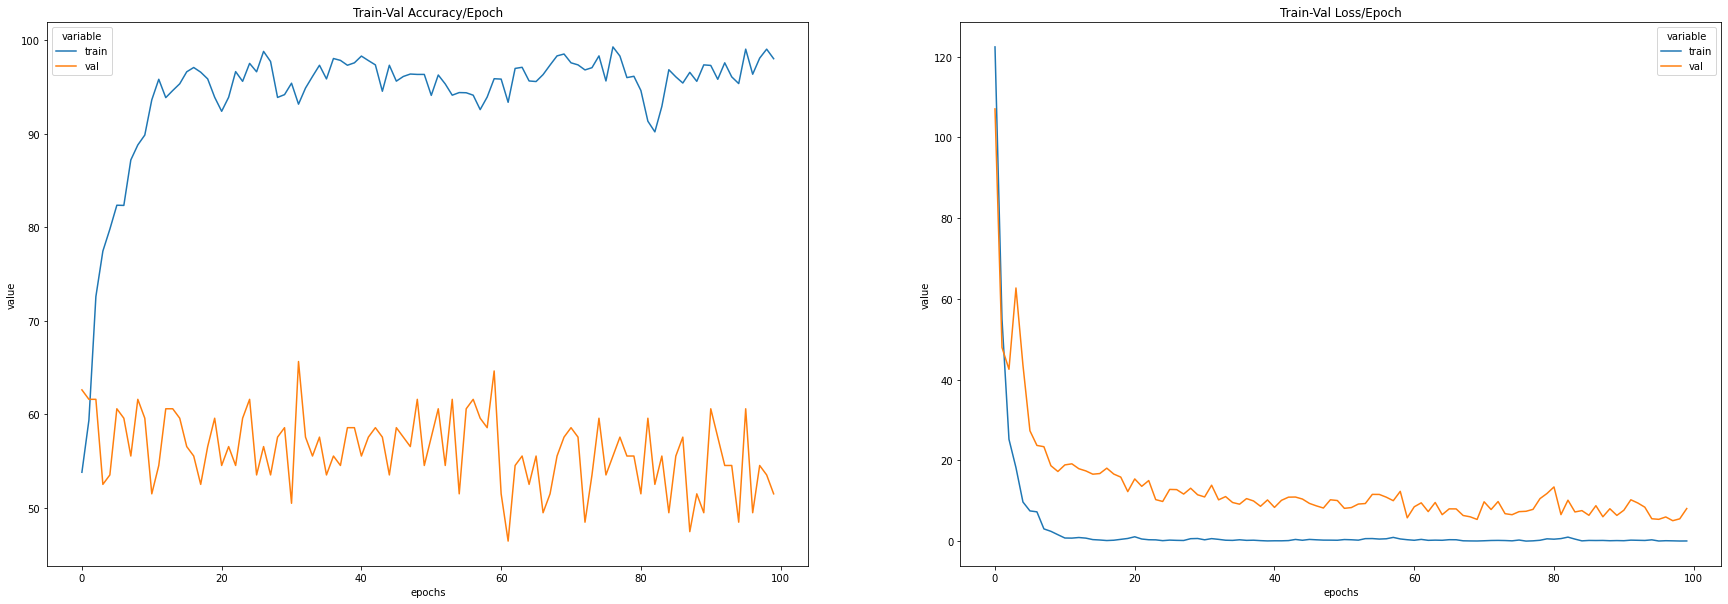

In [9]:
#Visualize Loss and Accuracy
#To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and 
#loss_stats dictionaries.

#print(len(accuracy_stats['train']))
#print(len(accuracy_stats['val']))
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# print((train_val_acc_df))

#print(len(loss_stats['train']))
#print(len(loss_stats['val']))
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
#print(train_val_loss_df)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')



In [10]:

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)        
        
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

#We’ll flatten out the list so that we can use it as an input to confusion_matrix and classification_report.        
y_pred_list = [i[0][0][0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]        


print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 149.05it/s]

y_pred_list[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0

In [11]:
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))


              precision    recall  f1-score   support

           0       0.54      0.68      0.60       250
           1       0.56      0.41      0.48       250

    accuracy                           0.55       500
   macro avg       0.55      0.55      0.54       500
weighted avg       0.55      0.55      0.54       500

[[170  80]
 [147 103]]


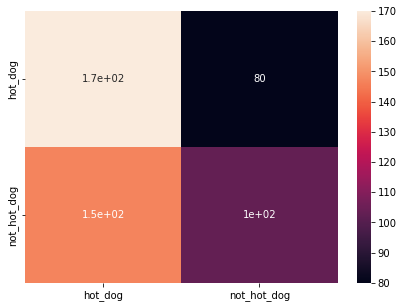

In [12]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()